In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import plotly.express as px
from tqdm import tqdm
import random

import optuna
from optuna.samplers import RandomSampler
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [2]:
import sys
sys.path.append('../src')

import vrpp
import importlib
importlib.reload(vrpp)

<module 'vrpp' from '/Users/sergak/Documents/Neyro_sets/optimal_encashement/notebooks/../src/vrpp.py'>

In [3]:
dist = pd.read_csv('../data/raw/times v4.csv')
le = preprocessing.LabelEncoder()
le.fit(dist['Origin_tid'])
dist['from_int'] = le.transform(dist['Origin_tid'])
dist['to_int'] = le.transform(dist['Destination_tid'])
dist.head()

,Origin_tid,Destination_tid,Total_Time,from_int,to_int
0,636538,683103,15.32,864,1354
1,636538,634763,16.20,864,624
2,636538,683128,16.27,864,1358
3,636538,683789,16.77,864,1374
4,636538,634709,17.67,864,603


In [4]:
data = pd.read_excel('../data/raw/terminal_data_hackathon v4.xlsx', 'Incomes')
data.head()

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,355000,50000,73000,53000,65000,75000,100000,53000,52000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,597000,96000,82000,71000,72000,86000,55000,55000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [5]:
config = {'num_terminals': dist['from_int'].max() + 1,
          'persent_day_income': 0.02 / 365,
          'terminal_service_cost': 100,
          'terminal_service_persent': 0, #0.01
          'max_terminal_money': 1000000,
          'max_not_service_days': 14,
          'armored_car_day_cost': 20000,
          'work_time': 10 * 60,
          'service_time': 10,
          'left_days_coef': 0,
          'encashment_coef': 0,}

In [17]:
income = (data[data.columns[1:]].values * (1 + 0.2 * (random.random() - 0.5))).copy()
real_cash = data[data.columns[1:]].values.copy()
# cash = real_cash.copy()

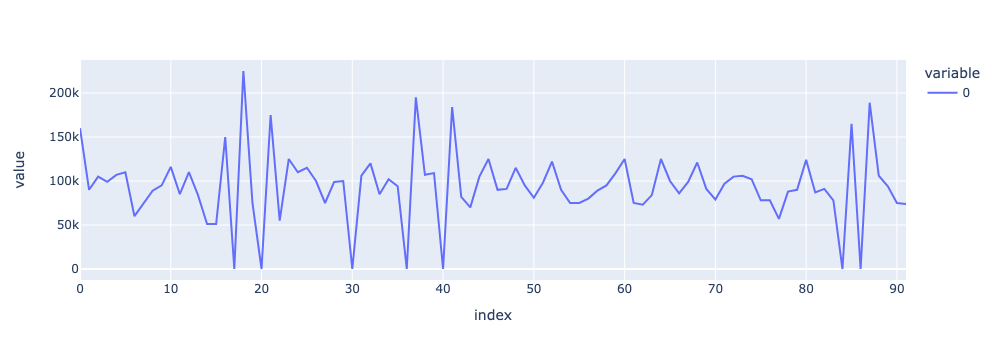

In [51]:
px.line(real_cash[0])

In [18]:
real_cash[0]

array([160000,  90000, 105000,  99000, 107000, 110000,  60000,  75000,
        89000,  95000, 116000,  85000, 110000,  84000,  51000,  51000,
       150000,      0, 225000,  75000,      0, 175000,  55000, 125000,
       110000, 115000, 100000,  75000,  99000, 100000,      0, 106000,
       120000,  85000, 102000,  94000,      0, 195000, 107000, 109000,
            0, 184000,  82000,  70000, 105000, 125000,  90000,  91000,
       115000,  95000,  81000,  98000, 122000,  90000,  75000,  75000,
        80000,  89000,  95000, 109000, 125000,  75000,  73000,  84000,
       125000, 100000,  86000,  99000, 121000,  91000,  79000,  97000,
       105000, 106000, 102000,  78000,  78000,  57000,  88000,  90000,
       124000,  87000,  91000,  78000,      0, 165000,      0, 189000,
       106000,  94000,  75000,  74000])

In [21]:
real_cash[2]

array([287000, 143000, 136000, 124000, 117000, 123000, 140000, 139000,
       138000, 118000, 126000, 113000, 103000, 154000, 130000, 132000,
       138000, 146000, 123000, 131000, 140000, 130000, 129000, 158000,
       119000, 113000, 122000, 135000, 116000, 137000,      0,      0,
       380000, 124000, 156000, 138000, 148000, 166000, 153000, 115000,
            0, 279000, 147000, 123000, 142000, 148000, 119000, 123000,
       133000, 139000, 165000, 149000, 139000, 112000, 136000, 150000,
       148000, 147000,      0, 136000, 130000, 121000, 132000, 145000,
       167000, 131000, 115000, 111000,      0, 274000, 132000, 179000,
       140000, 139000,      0,      0, 366000, 167000, 100000,  73000,
       130000, 104000, 119000, 100000, 179000, 169000, 118000, 118000,
       114000, 128000, 121000, 124000])

In [27]:
np.cumsum(real_cash, axis=1).shape

(1630, 92)

In [41]:
df = pd.DataFrame({'cumsum': np.cumsum(real_cash, axis=1).flatten(),
                   'tid': np.arange(1630 * 92) // 92,
                   'x': np.arange(92).tolist() * 1630})
df.head()

,cumsum,tid,x
0,160000,0,0
1,250000,0,1
2,355000,0,2
3,454000,0,3
4,561000,0,4


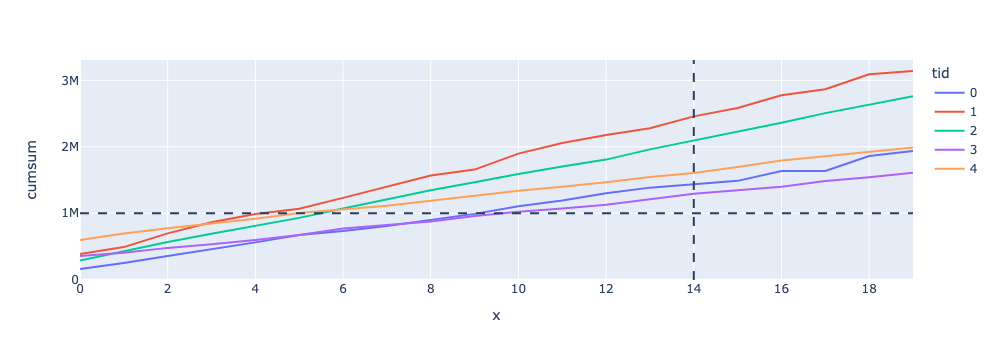

In [47]:
fig = px.line(df[(df['tid'] < 5) & (df['x'] < 20)], y='cumsum', x='x', color='tid')
fig.add_vline(x=14, line_dash="dash",)
fig.add_hline(y=1e6, line_dash="dash",)
fig.show()

In [13]:
cash = cash.astype(int)
cash.shape

(1630, 92)

In [14]:
INF = 1e9

In [15]:
def get_cost(days_left):
    if days_left == 0: return INF
    # return 2 ** (config['max_not_service_days'] - days_left)
    l = 10000 / (2 ** days_left)
    # return 1 if days_left > 2 else l
    return 256 * l if days_left == big_id and days_left > 7 else l

In [16]:
cash = income.copy()
num_vehicles = 5
num_terminals = cash.shape[0]
time_until_force = [config['max_not_service_days'] for i in range(num_terminals)]
cur_cash = cash[:, 0]
cash = cash[:, 1:]

hist = {'visited': [], 'loss': []}
bad = False

myvrp = vrpp.VRPP(dist, 10, 10 * 60, num_vehicles, solution_limit=100, time_limit=100, dead_loss=False)

days = 90
big_id = config['max_not_service_days']
for day in tqdm(range(days)):
    mask = []
    cost = []
    to_counter = [0 for i in range(config['max_not_service_days'] + 1)]
    
    for i in range(num_terminals):
        current_money = cur_cash[i]
        force = time_until_force[i]
        for forecast in range(min(force, days - day)):
            if current_money > config['max_terminal_money']:
                force = forecast
                break
            if not forecast:
                current_money += cash[i][day + forecast]
            else:
                current_money += cash[i][day + forecast] # check later
        mask.append(1)
        cost.append(int(get_cost(force)))
        to_counter[force] += 1
    
    print(to_counter)
    # # for i in range(100):
    # #     print(" " * (4 - len(str(cost[i]))) + str(cost[i]), end=' ')
    # # print()
    # print(" "cost[:100])
    
    visited, paths = myvrp.find_vrp(cost, mask)
    hist['visited'].append(visited)
    
    prev = []
    cur_loss = 0
    for i in range(num_terminals):
        if cur_cash[i] > config['max_terminal_money'] or time_until_force[i] == 0:
            if not visited[i]:
                print('Dead')
                bad = True
                break

        if visited[i]:
            cur_loss += max(config['terminal_service_cost'], cur_cash[i] * config['terminal_service_persent'])
            cur_cash[i] = 0
            time_until_force[i] = config['max_not_service_days']
        else:
            time_until_force[i] -= 1 
            
        cur_loss += cur_cash[i] * config['persent_day_income']
        cur_cash[i] += real_cash[i][day]
    
    if bad:
        break
    
    hist['loss'].append(cur_loss)
    big_id -= 1
    
print(sum(hist['loss']))

  0%|                                                                                                          | 0/90 [00:00<?, ?it/s]

[10, 7, 21, 35, 36, 42, 62, 63, 61, 76, 92, 79, 81, 79, 886]


  1%|█                                                                                                 | 1/90 [00:07<10:24,  7.02s/it]

[0, 2, 1, 8, 42, 72, 74, 75, 86, 105, 90, 88, 87, 887, 13]


  2%|██▏                                                                                               | 2/90 [00:23<18:13, 12.42s/it]

[0, 2, 1, 2, 73, 78, 81, 91, 107, 94, 92, 91, 782, 21, 115]


  3%|███▎                                                                                              | 3/90 [00:40<20:57, 14.45s/it]

[1, 1, 2, 53, 77, 85, 94, 111, 95, 92, 92, 601, 23, 118, 185]


  4%|████▎                                                                                             | 4/90 [00:52<19:32, 13.64s/it]

[0, 2, 40, 76, 86, 95, 113, 97, 92, 92, 419, 27, 121, 185, 185]


  6%|█████▍                                                                                            | 5/90 [01:07<20:01, 14.14s/it]

[0, 27, 75, 86, 96, 112, 97, 93, 92, 260, 29, 124, 187, 189, 163]


  7%|██████▌                                                                                           | 6/90 [01:30<24:09, 17.26s/it]

[14, 72, 84, 96, 112, 98, 93, 92, 110, 31, 125, 189, 192, 168, 154]


  8%|███████▌                                                                                          | 7/90 [01:42<21:22, 15.45s/it]

[60, 84, 96, 113, 101, 92, 92, 21, 33, 128, 190, 193, 172, 158, 97]


  9%|████████▋                                                                                         | 8/90 [01:50<18:01, 13.19s/it]

[20, 89, 112, 102, 97, 99, 32, 49, 137, 199, 203, 178, 163, 104, 46]


 10%|█████████▊                                                                                        | 9/90 [02:01<16:42, 12.38s/it]

[5, 99, 102, 96, 99, 35, 51, 147, 208, 211, 186, 174, 111, 54, 52]


 11%|██████████▊                                                                                      | 10/90 [02:19<18:59, 14.25s/it]

[6, 91, 96, 101, 35, 53, 149, 212, 215, 192, 182, 118, 64, 57, 59]


 12%|███████████▊                                                                                     | 11/90 [02:29<16:59, 12.90s/it]

[2, 83, 99, 35, 52, 152, 213, 217, 190, 186, 127, 75, 62, 65, 72]


 13%|████████████▉                                                                                    | 12/90 [02:38<14:57, 11.50s/it]

[0, 74, 36, 53, 153, 217, 218, 190, 189, 128, 79, 67, 73, 80, 73]


 14%|██████████████                                                                                   | 13/90 [02:52<15:49, 12.34s/it]

[0, 6, 42, 152, 218, 225, 201, 194, 128, 79, 70, 75, 87, 80, 73]


 16%|███████████████                                                                                  | 14/90 [02:57<12:56, 10.22s/it]

[1, 0, 78, 216, 226, 202, 202, 138, 86, 74, 79, 87, 83, 79, 79]


 17%|████████████████▏                                                                                | 15/90 [03:22<18:24, 14.73s/it]

[0, 1, 119, 225, 205, 209, 140, 92, 86, 86, 90, 86, 82, 82, 127]


 18%|█████████████████▏                                                                               | 16/90 [03:36<17:42, 14.36s/it]

[0, 1, 163, 204, 211, 141, 94, 87, 90, 95, 88, 86, 84, 129, 157]


 19%|██████████████████▎                                                                              | 17/90 [03:53<18:31, 15.22s/it]

[0, 3, 192, 210, 144, 100, 90, 93, 100, 95, 90, 88, 131, 160, 134]


 20%|███████████████████▍                                                                             | 18/90 [04:07<17:55, 14.93s/it]

[0, 34, 205, 145, 99, 91, 98, 101, 97, 96, 91, 136, 163, 138, 136]


 21%|████████████████████▍                                                                            | 19/90 [04:18<16:08, 13.64s/it]

[0, 97, 144, 99, 89, 104, 105, 100, 99, 95, 144, 168, 143, 140, 103]


 22%|█████████████████████▌                                                                           | 20/90 [04:30<15:12, 13.03s/it]

[0, 108, 95, 89, 102, 109, 100, 101, 96, 147, 175, 150, 142, 110, 106]


 23%|██████████████████████▋                                                                          | 21/90 [04:40<14:11, 12.34s/it]

[5, 82, 89, 103, 110, 102, 102, 104, 150, 180, 155, 149, 114, 111, 74]


 24%|███████████████████████▋                                                                         | 22/90 [05:00<16:25, 14.50s/it]

[0, 59, 102, 111, 104, 107, 109, 155, 191, 157, 159, 121, 118, 83, 54]


 26%|████████████████████████▊                                                                        | 23/90 [05:19<17:41, 15.84s/it]

[0, 35, 106, 106, 110, 109, 162, 195, 166, 166, 129, 123, 94, 59, 70]


 27%|█████████████████████████▊                                                                       | 24/90 [05:32<16:26, 14.95s/it]

[0, 17, 97, 110, 110, 170, 200, 167, 170, 135, 128, 99, 70, 75, 82]


 28%|██████████████████████████▉                                                                      | 25/90 [05:40<13:55, 12.85s/it]

[0, 11, 103, 110, 172, 201, 168, 172, 139, 138, 101, 74, 77, 88, 76]


 29%|████████████████████████████                                                                     | 26/90 [06:00<16:04, 15.07s/it]

[1, 6, 98, 169, 205, 172, 174, 144, 139, 105, 78, 82, 93, 82, 82]


 30%|█████████████████████████████                                                                    | 27/90 [06:08<13:47, 13.13s/it]

[1, 1, 130, 206, 173, 179, 150, 145, 110, 80, 86, 98, 85, 87, 99]


 31%|██████████████████████████████▏                                                                  | 28/90 [06:21<13:31, 13.09s/it]

[0, 2, 172, 173, 179, 157, 148, 114, 83, 92, 100, 91, 90, 102, 127]


 32%|███████████████████████████████▎                                                                 | 29/90 [07:00<21:04, 20.72s/it]

[0, 9, 164, 181, 161, 150, 117, 92, 99, 103, 96, 94, 104, 129, 131]


 33%|████████████████████████████████▎                                                                | 30/90 [07:07<16:41, 16.69s/it]

[0, 23, 173, 163, 149, 122, 94, 104, 108, 101, 98, 110, 132, 134, 119]


 34%|█████████████████████████████████▍                                                               | 31/90 [07:20<15:19, 15.58s/it]

[1, 37, 158, 150, 120, 98, 106, 111, 104, 105, 118, 137, 137, 123, 125]


 36%|██████████████████████████████████▍                                                              | 32/90 [07:32<13:48, 14.29s/it]

[0, 61, 142, 119, 101, 109, 118, 107, 113, 122, 143, 146, 131, 130, 88]


 37%|███████████████████████████████████▌                                                             | 33/90 [07:49<14:20, 15.10s/it]

[0, 63, 112, 103, 111, 125, 111, 118, 125, 151, 151, 137, 136, 93, 94]


 38%|████████████████████████████████████▋                                                            | 34/90 [08:03<13:52, 14.87s/it]

[0, 47, 96, 111, 124, 114, 124, 130, 152, 155, 141, 142, 103, 100, 91]


 39%|█████████████████████████████████████▋                                                           | 35/90 [08:11<11:52, 12.95s/it]

[0, 35, 109, 125, 117, 126, 134, 157, 160, 144, 148, 110, 105, 97, 63]


 40%|██████████████████████████████████████▊                                                          | 36/90 [08:40<16:00, 17.78s/it]

[0, 26, 116, 118, 127, 140, 160, 164, 152, 154, 118, 112, 101, 70, 72]


 41%|███████████████████████████████████████▉                                                         | 37/90 [09:00<16:04, 18.20s/it]

[0, 21, 109, 128, 141, 163, 170, 157, 160, 123, 113, 106, 74, 78, 87]


 42%|████████████████████████████████████████▉                                                        | 38/90 [09:15<15:09, 17.50s/it]

[0, 19, 116, 142, 163, 177, 160, 164, 125, 116, 112, 80, 85, 92, 79]


 43%|██████████████████████████████████████████                                                       | 39/90 [09:24<12:31, 14.73s/it]

[0, 16, 134, 164, 177, 161, 168, 132, 122, 121, 84, 86, 96, 80, 89]


 44%|███████████████████████████████████████████                                                      | 40/90 [09:40<12:37, 15.15s/it]

[0, 11, 156, 175, 166, 173, 133, 127, 123, 90, 90, 103, 85, 94, 104]


 46%|████████████████████████████████████████████▏                                                    | 41/90 [09:49<10:50, 13.28s/it]

[0, 30, 173, 167, 173, 136, 130, 127, 91, 95, 107, 88, 94, 106, 113]


 47%|█████████████████████████████████████████████▎                                                   | 42/90 [10:04<11:04, 13.84s/it]

[0, 38, 165, 173, 137, 135, 132, 98, 99, 114, 94, 103, 108, 117, 117]


 48%|██████████████████████████████████████████████▎                                                  | 43/90 [10:38<15:40, 20.00s/it]

[0, 42, 170, 137, 136, 134, 105, 100, 119, 96, 108, 112, 121, 123, 127]


 49%|███████████████████████████████████████████████▍                                                 | 44/90 [10:53<14:06, 18.40s/it]

[1, 58, 131, 137, 135, 108, 104, 127, 100, 117, 119, 126, 128, 134, 105]


 50%|████████████████████████████████████████████████▌                                                | 45/90 [11:04<12:05, 16.12s/it]

[0, 58, 129, 134, 110, 106, 130, 108, 117, 124, 136, 135, 142, 111, 90]


 51%|█████████████████████████████████████████████████▌                                               | 46/90 [11:16<10:56, 14.93s/it]

[0, 54, 134, 109, 104, 134, 110, 117, 126, 139, 137, 144, 113, 93, 116]


 52%|██████████████████████████████████████████████████▋                                              | 47/90 [11:26<09:38, 13.45s/it]

[0, 48, 104, 104, 135, 114, 123, 139, 145, 142, 152, 121, 98, 120, 85]


 53%|███████████████████████████████████████████████████▋                                             | 48/90 [11:33<07:59, 11.41s/it]

[0, 46, 99, 133, 117, 126, 141, 148, 146, 157, 126, 102, 123, 91, 75]


 54%|████████████████████████████████████████████████████▊                                            | 49/90 [11:39<06:50, 10.02s/it]

[0, 19, 134, 118, 126, 146, 153, 147, 161, 130, 106, 127, 98, 83, 82]


 56%|█████████████████████████████████████████████████████▉                                           | 50/90 [12:01<08:59, 13.48s/it]

[1, 29, 109, 126, 149, 154, 152, 166, 136, 113, 134, 104, 85, 88, 84]


 57%|██████████████████████████████████████████████████████▉                                          | 51/90 [12:35<12:46, 19.66s/it]

[0, 19, 123, 147, 157, 156, 169, 142, 120, 137, 107, 89, 97, 85, 82]


 58%|████████████████████████████████████████████████████████                                         | 52/90 [12:46<10:45, 16.99s/it]

[0, 14, 138, 159, 154, 172, 147, 121, 140, 116, 98, 104, 88, 84, 95]


 59%|█████████████████████████████████████████████████████████                                        | 53/90 [13:03<10:33, 17.13s/it]

[0, 8, 154, 152, 175, 153, 123, 148, 119, 102, 108, 93, 89, 99, 107]


 60%|██████████████████████████████████████████████████████████▏                                      | 54/90 [13:17<09:43, 16.22s/it]

[0, 15, 149, 176, 153, 127, 151, 123, 111, 110, 99, 92, 106, 108, 110]


 61%|███████████████████████████████████████████████████████████▎                                     | 55/90 [13:26<08:07, 13.92s/it]

[1, 21, 171, 153, 127, 154, 126, 113, 114, 107, 94, 115, 112, 115, 107]


 62%|████████████████████████████████████████████████████████████▎                                    | 56/90 [13:42<08:21, 14.75s/it]

[0, 28, 147, 128, 159, 130, 117, 119, 114, 97, 118, 115, 124, 110, 124]


 63%|█████████████████████████████████████████████████████████████▍                                   | 57/90 [14:07<09:46, 17.77s/it]

[0, 27, 125, 160, 132, 122, 122, 119, 102, 125, 122, 130, 113, 128, 103]


 64%|██████████████████████████████████████████████████████████████▌                                  | 58/90 [14:19<08:28, 15.89s/it]

[0, 8, 150, 132, 120, 129, 124, 107, 133, 126, 138, 120, 135, 106, 102]


 66%|███████████████████████████████████████████████████████████████▌                                 | 59/90 [14:26<06:47, 13.16s/it]

[0, 21, 120, 121, 130, 128, 111, 137, 131, 141, 125, 137, 114, 107, 107]


 67%|████████████████████████████████████████████████████████████████▋                                | 60/90 [14:33<05:47, 11.57s/it]

[0, 25, 111, 130, 130, 115, 137, 134, 143, 130, 146, 123, 116, 112, 78]


 68%|█████████████████████████████████████████████████████████████████▋                               | 61/90 [14:47<05:51, 12.13s/it]

[0, 12, 126, 129, 118, 143, 135, 148, 136, 150, 130, 119, 114, 84, 86]


 69%|██████████████████████████████████████████████████████████████████▊                              | 62/90 [15:05<06:32, 14.01s/it]

[0, 11, 127, 119, 142, 140, 154, 144, 150, 132, 125, 118, 88, 93, 87]


 70%|███████████████████████████████████████████████████████████████████▉                             | 63/90 [15:15<05:40, 12.62s/it]

[0, 17, 113, 143, 143, 157, 149, 155, 138, 132, 124, 93, 98, 91, 77]


 71%|████████████████████████████████████████████████████████████████████▉                            | 64/90 [15:33<06:15, 14.45s/it]

[0, 24, 130, 143, 160, 153, 156, 145, 136, 126, 96, 99, 96, 79, 87]


 72%|██████████████████████████████████████████████████████████████████████                           | 65/90 [15:50<06:21, 15.25s/it]

[0, 35, 142, 160, 155, 160, 149, 141, 133, 99, 103, 104, 83, 92, 74]


 73%|███████████████████████████████████████████████████████████████████████▏                         | 66/90 [16:01<05:33, 13.90s/it]

[0, 35, 155, 155, 160, 154, 141, 136, 103, 106, 112, 89, 92, 76, 116]


 74%|████████████████████████████████████████████████████████████████████████▏                        | 67/90 [16:24<06:23, 16.66s/it]

[0, 36, 155, 160, 157, 143, 145, 106, 109, 114, 96, 97, 82, 122, 108]


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 68/90 [16:37<05:38, 15.37s/it]

[0, 36, 156, 157, 144, 151, 107, 116, 123, 99, 100, 86, 126, 110, 119]


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 69/90 [17:00<06:10, 17.66s/it]

[0, 45, 153, 141, 152, 109, 118, 127, 104, 102, 88, 132, 118, 122, 119]


 78%|███████████████████████████████████████████████████████████████████████████▍                     | 70/90 [17:21<06:17, 18.87s/it]

[0, 48, 139, 153, 112, 123, 129, 109, 110, 91, 142, 126, 128, 123, 97]


 79%|████████████████████████████████████████████████████████████████████████████▌                    | 71/90 [17:54<07:16, 22.97s/it]

[0, 45, 146, 113, 124, 131, 117, 114, 96, 147, 133, 131, 131, 104, 98]


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 72/90 [18:04<05:41, 18.95s/it]

[0, 60, 112, 123, 132, 121, 117, 101, 152, 139, 139, 134, 107, 102, 91]


 81%|██████████████████████████████████████████████████████████████████████████████▋                  | 73/90 [18:22<05:20, 18.84s/it]

[0, 41, 112, 133, 126, 119, 104, 156, 140, 142, 138, 109, 105, 98, 107]


 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 74/90 [18:37<04:40, 17.53s/it]

[0, 34, 129, 125, 120, 106, 162, 141, 143, 142, 112, 111, 102, 110, 93]


 83%|████████████████████████████████████████████████████████████████████████████████▊                | 75/90 [18:46<03:45, 15.06s/it]

[0, 45, 116, 123, 107, 166, 146, 149, 148, 115, 115, 109, 112, 100, 79]


 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 76/90 [18:57<03:13, 13.81s/it]

[0, 43, 118, 107, 169, 150, 153, 151, 122, 122, 115, 117, 103, 79, 81]


 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 77/90 [19:28<04:06, 18.96s/it]

[0, 32, 103, 172, 152, 157, 156, 125, 128, 118, 118, 108, 81, 81, 99]


 87%|████████████████████████████████████████████████████████████████████████████████████             | 78/90 [19:34<03:00, 15.04s/it]

[0, 23, 167, 150, 158, 160, 130, 131, 126, 121, 111, 85, 81, 99, 88]


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 79/90 [19:46<02:36, 14.22s/it]

[0, 42, 145, 159, 160, 134, 138, 129, 127, 116, 89, 81, 99, 88, 123]


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 80/90 [20:00<02:22, 14.24s/it]

[0, 38, 157, 159, 135, 140, 133, 131, 119, 92, 81, 99, 88, 123, 135]


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 81/90 [20:24<02:33, 17.00s/it]

[0, 40, 157, 135, 142, 137, 134, 124, 94, 81, 99, 88, 123, 135, 141]


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 82/90 [20:32<01:54, 14.33s/it]

[0, 49, 136, 143, 138, 138, 126, 99, 81, 99, 88, 123, 135, 141, 134]


 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 83/90 [20:52<01:52, 16.14s/it]

[0, 38, 140, 139, 141, 130, 105, 80, 99, 88, 123, 135, 141, 134, 137]


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 84/90 [21:06<01:33, 15.58s/it]

[0, 32, 137, 142, 132, 108, 80, 99, 88, 123, 135, 141, 134, 137, 142]


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 85/90 [21:22<01:18, 15.62s/it]

[0, 45, 137, 132, 111, 79, 99, 86, 123, 135, 141, 134, 136, 142, 130]


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 86/90 [21:51<01:18, 19.58s/it]

[1, 36, 133, 108, 79, 99, 86, 123, 135, 141, 134, 136, 142, 130, 147]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 87/90 [22:13<01:01, 20.38s/it]

[0, 36, 104, 77, 97, 86, 123, 134, 141, 134, 136, 142, 130, 147, 143]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 88/90 [22:21<00:33, 16.63s/it]

[0, 20, 71, 96, 86, 122, 134, 141, 134, 136, 142, 130, 146, 143, 129]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 89/90 [22:30<00:14, 14.30s/it]

[0, 0, 58, 83, 122, 134, 141, 133, 136, 142, 130, 146, 143, 129, 133]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [22:37<00:00, 15.09s/it]

3552557.0132625


## Add optuna

In [13]:
def predict(trial, num_vehicles=5, verbose=True):
    
    coefs = [trial.suggest_int('coef_{}'.format(i), 0, 100, step=5, log=False) for i in range(config['max_not_service_days'])]
    def get_cost(days_left):
        if days_left == 0: return INF
        # return 2 ** (config['max_not_service_days'] - days_left)
        # return int(10000 / (2 ** days_left))
        return coefs[days_left]
    
    num_terminals = cash.shape[0]
    time_until_force = [config['max_not_service_days'] - 1 for i in range(num_terminals)]
    cur_cash = np.zeros(num_terminals)
    hist = {'visited': [], 'loss': []}
    bad = False

    myvrp = vrpp.VRPP(dist, 10, 10 * 60, num_vehicles, solution_limit=100, time_limit=100, dead_loss=False)

    
    
    days = 31
    if verbose:
        iterator = tqdm(range(days))
    else:
        iterator = range(days)
    sum_inf = 0
    for day in iterator:
        mask = []
        cost = []
        for i in range(num_terminals):
            current_money = cur_cash[i]
            force = time_until_force[i]
            for forecast in range(force):
                if current_money > config['max_terminal_money']:
                    force = forecast
                    break
                if not forecast:
                    current_money += cash[i][day + forecast]
                else:
                    current_money += cash[i][day + forecast] # check later
            mask.append(1)
            cost.append(int(get_cost(force)))
        
        visited, paths = myvrp.find_vrp(cost, mask)
        hist['visited'].append(visited)

        prev = []
        cur_loss = 0
        for i in range(num_terminals):
            if cur_cash[i] > config['max_terminal_money'] or time_until_force[i] == 0:
                if not visited[i]:
                    print('Dead')
                    return sum_inf

            if visited[i]:
                cur_loss += config['terminal_service_cost']
                cur_cash[i] = 0
                time_until_force[i] = 14


            time_until_force[i] -= 1 
            cur_loss += cur_cash[i] * config['persent_day_income']
            cur_cash[i] += real_cash[i][day]

        for i in range(num_terminals):
            sum_inf += time_until_force[i] <= 1

        hist['loss'].append(cur_loss)
        
    return 0

In [14]:
import optuna
from optuna.samplers import RandomSampler
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.ERROR)


In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=42,
                                               multivariate=True,
                                               warn_independent_sampling=False,), )

study.optimize(lambda trial: predict(trial, 5, False),
               n_trials=100,
               n_jobs=6,
               show_progress_bar=True,)

  0%|                                                                                                         | 0/100 [00:00<?, ?it/s]